# Custom MLP Implementation on US Census Data

By: Joe Sellett, Haiyan Cai, and Cole Wagner

## Load, Split, and Balance Data

In [80]:
import itertools
import sys

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.special import expit
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from statsmodels.stats.contingency_tables import mcnemar


In [2]:
# Load the data as a pandas DataFrame
census_data = pd.read_csv("acs2017_census_tract_data.csv")

In [3]:
census_data.head()
census_data.shape

(74001, 37)

In [4]:
# Remove any rows with missing values
census_nona = census_data.dropna()

In [5]:
census_nona.info()

<class 'pandas.core.frame.DataFrame'>
Index: 72718 entries, 0 to 74000
Data columns (total 37 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   TractId           72718 non-null  int64  
 1   State             72718 non-null  object 
 2   County            72718 non-null  object 
 3   TotalPop          72718 non-null  int64  
 4   Men               72718 non-null  int64  
 5   Women             72718 non-null  int64  
 6   Hispanic          72718 non-null  float64
 7   White             72718 non-null  float64
 8   Black             72718 non-null  float64
 9   Native            72718 non-null  float64
 10  Asian             72718 non-null  float64
 11  Pacific           72718 non-null  float64
 12  VotingAgeCitizen  72718 non-null  int64  
 13  Income            72718 non-null  float64
 14  IncomeErr         72718 non-null  float64
 15  IncomePerCap      72718 non-null  float64
 16  IncomePerCapErr   72718 non-null  float64
 17

In [6]:
# Encode State column as integers

# Sort states alphabetically
unique_states = sorted(census_nona["State"].unique())
# Create a dictionary to map states to integers
state_to_int = {state: i + 1 for i, state in enumerate(unique_states)}
# Map the states to integers
census_nona["State"] = census_nona["State"].map(state_to_int)


/var/folders/jk/68j7w1pn443f9hrnsrlvphpw0000gn/T/ipykernel_53531/2779392074.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  census_nona["State"] = census_nona["State"].map(state_to_int)


In [7]:
census_nona["County"].value_counts()

County
Los Angeles County    2300
Cook County           1317
Orange County          929
Maricopa County        885
Montgomery County      822
                      ... 
Buena Vista city         1
Meagher County           1
Norton County            1
McCone County            1
Schleicher County        1
Name: count, Length: 1954, dtype: int64

In [8]:
# Drop the County column
census_nona = census_nona.drop(columns=["County"])

We decided to remove the County column due to the large number of categories. Using this in a model would require introducing almost 2000 columns into our dataset using one-hot encoding.

We believe that quantizing the data must be done separately for the training and testing data to prevent data leakage. We do not want the quantization of the testing data to be influenced by the training data. We will use the training data to determine the quantization bins and then apply the same bins to the testing data.

In [9]:
# Perform 80/20 train-test split
x_train, x_test, y_train, y_test = train_test_split(
    # Use all columns except ChildPoverty and TractId as features
    census_nona.drop(columns=["ChildPoverty", "TractId"]),
    census_nona["ChildPoverty"],
    test_size=0.2,
    random_state=7324,
)

<Axes: >

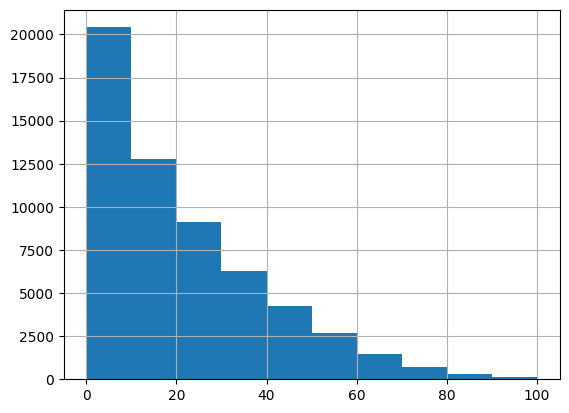

In [10]:
y_train.hist()

<Axes: >

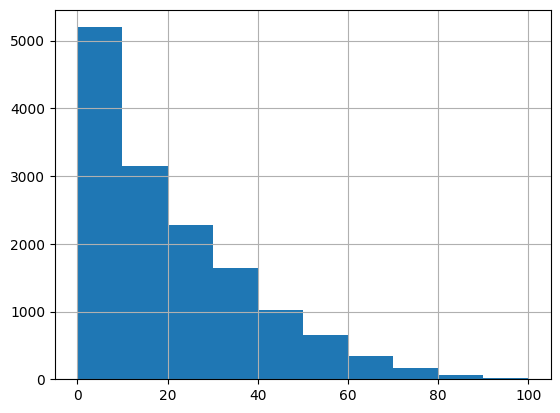

In [11]:
y_test.hist()

From the histograms above, we confirm that the distribution of ChildPoverty is similar in the training and testing sets.

In [12]:
# Quantize the training labels
y_train_cat, cuts = pd.qcut(
    y_train, q=4, labels=[0, 1, 2, 3], retbins=True
)

# Apply the same quantization to the test labels
y_test_cat = []
for y in y_test:
    if y < cuts[1]:
        y_test_cat.append(0)
    elif y < cuts[2]:
        y_test_cat.append(1)
    elif y < cuts[3]:
        y_test_cat.append(2)
    else:
        y_test_cat.append(3)

In [13]:
y_test_cat = np.array(y_test_cat)

## Preprocessing and Initial Modeling

### Create MLP Classes

From https://github.com/eclarson/MachineLearningNotebooks/blob/master/08a.%20Practical_NeuralNets%20with%20Bias.ipynb

In [14]:
# start with a simple base classifier, which can't be fit or predicted
# it only has internal classes to be used by classes that will subclass it
class TwoLayerPerceptronBase(object):
    def __init__(
        self,
        n_hidden=30,
        C=0.0,
        epochs=500,
        eta=0.00001,
        random_state=None,
    ):
        np.random.seed(random_state)
        self.n_hidden = n_hidden
        self.l2_C = C
        self.epochs = epochs
        self.eta = eta

    @staticmethod
    def _encode_labels(y):
        """Encode labels into one-hot representation"""
        onehot = pd.get_dummies(y).values.T

        return onehot

    def _initialize_weights(self):
        """Initialize weights with small random numbers."""
        W1_num_elems = (self.n_features_) * self.n_hidden
        W1 = np.random.uniform(-1.0, 1.0, size=W1_num_elems)
        W1 = W1.reshape(self.n_hidden, self.n_features_)  # reshape to be W
        b1 = np.zeros((self.n_hidden, 1))

        W2_num_elems = (self.n_hidden) * self.n_output_
        W2 = np.random.uniform(-1.0, 1.0, size=W2_num_elems)
        W2 = W2.reshape(self.n_output_, self.n_hidden)
        b2 = np.zeros((self.n_output_, 1))

        return W1, W2, b1, b2

    @staticmethod
    def _sigmoid(z):
        """Use scipy.special.expit to avoid overflow"""
        # 1.0 / (1.0 + np.exp(-z))
        return expit(z)

    @staticmethod
    def _L2_reg(lambda_, W1, W2):
        """Compute L2-regularization cost"""
        # only compute for non-bias terms
        return (lambda_ / 2.0) * np.sqrt(
            np.mean(W1[:, 1:] ** 2) + np.mean(W2[:, 1:] ** 2)
        )

    def _cost(self, A3, Y_enc, W1, W2):
        """Get the objective function value"""
        cost = np.mean((Y_enc - A3) ** 2)
        L2_term = self._L2_reg(self.l2_C, W1, W2)
        return cost + L2_term

    def _feedforward(self, X, W1, W2, b1, b2):
        """Compute feedforward step.

        -----------
        X : Input layer with original features.
        W1: Weight matrix for input layer -> hidden layer.
        W2: Weight matrix for hidden layer -> output layer.
        ----------
        a1-a3 : activations into layer (or output layer)
        z1-z2 : layer inputs

        """
        A1 = X.T
        Z1 = W1 @ A1 + b1
        A2 = self._sigmoid(Z1)
        Z2 = W2 @ A2 + b2
        A3 = self._sigmoid(Z2)
        return A1, Z1, A2, Z2, A3

    def _get_gradient(self, A1, A2, A3, Z1, Z2, Y_enc, W1, W2):
        """Compute gradient step using backpropagation."""
        # vectorized backpropagation
        # This uses MSE as cost function
        V2 = -2 * (Y_enc - A3) * A3 * (1 - A3)
        V1 = A2 * (1 - A2) * (W2.T @ V2)

        gradW2 = V2 @ A2.T
        gradW1 = V1 @ A1.T

        gradb2 = np.sum(V2, axis=1).reshape((-1, 1))
        gradb1 = np.sum(V1, axis=1).reshape((-1, 1))

        # regularize weights that are not bias terms
        gradW1 += W1 * self.l2_C
        gradW2 += W2 * self.l2_C

        return gradW1, gradW2, gradb1, gradb2

    def predict(self, X):
        """Predict class labels."""
        _, _, _, _, A3 = self._feedforward(
            X, self.W1, self.W2, self.b1, self.b2
        )
        y_pred = np.argmax(A3, axis=0)
        return y_pred

In [15]:
# just start with the vectorized version and minibatch
class TLPMiniBatch(TwoLayerPerceptronBase):
    def __init__(
        self,
        shuffle=True,
        minibatches=1,
        **kwds,
    ):
        # need to add to the original initializer
        self.shuffle = shuffle
        self.minibatches = minibatches
        # but keep other keywords
        super().__init__(**kwds)

    def fit(self, X, y, print_progress=False, XY_test=None):
        """Learn weights from training data. With mini-batch"""
        X_data, y_data = X.copy(), y.copy()
        Y_enc = self._encode_labels(y)

        # init weights and setup matrices
        self.n_features_ = X_data.shape[1]
        self.n_output_ = Y_enc.shape[0]
        self.W1, self.W2, self.b1, self.b2 = self._initialize_weights()
        self.cost_ = []
        self.score_ = []
        # get starting acc
        self.score_.append(accuracy_score(y_data, self.predict(X_data)))
        # keep track of validation, if given
        if XY_test is not None:
            X_test = XY_test[0].copy()
            y_test = XY_test[1].copy()
            self.val_score_ = []
            self.val_score_.append(
                accuracy_score(y_test, self.predict(X_test))
            )
            self.val_cost_ = []

        for i in range(self.epochs):
            if print_progress > 0 and (i + 1) % print_progress == 0:
                sys.stderr.write("\rEpoch: %d/%d" % (i + 1, self.epochs))
                sys.stderr.flush()

            if self.shuffle:
                idx_shuffle = np.random.permutation(y_data.shape[0])
                X_data, Y_enc, y_data = (
                    X_data[idx_shuffle],
                    Y_enc[:, idx_shuffle],
                    y_data[idx_shuffle],
                )

            mini = np.array_split(range(y_data.shape[0]), self.minibatches)
            mini_cost = []
            for idx in mini:
                # feedforward
                A1, Z1, A2, Z2, A3 = self._feedforward(
                    X_data[idx], self.W1, self.W2, self.b1, self.b2
                )

                cost = self._cost(A3, Y_enc[:, idx], self.W1, self.W2)
                mini_cost.append(
                    cost
                )  # this appends cost of mini-batch only

                # compute gradient via backpropagation
                gradW1, gradW2, gradb1, gradb2 = self._get_gradient(
                    A1=A1,
                    A2=A2,
                    A3=A3,
                    Z1=Z1,
                    Z2=Z2,
                    Y_enc=Y_enc[:, idx],
                    W1=self.W1,
                    W2=self.W2,
                )

                # uUdate weights and biases
                rho_W1, rho_W2 = self.eta * gradW1, self.eta * gradW2
                self.W1 -= rho_W1
                self.W2 -= rho_W2
                self.b1 -= self.eta * gradb1
                self.b2 -= self.eta * gradb2

            self.cost_.append(np.mean(mini_cost))
            self.score_.append(
                accuracy_score(y_data, self.predict(X_data))
            )

            # update if a validation set was provided
            if XY_test is not None:
                yhat = self.predict(X_test)
                self.val_score_.append(accuracy_score(y_test, yhat))

        return self

    def get_params(self, deep=True) -> dict:
        """Get the parameters of the model.

        Parameters
        ----------
        deep : bool, optional (default=True)
            Required parameter for compatibility with sklearn.

        Returns
        -------
        dict
            Parameters of the model.

        """
        return {
            "eta": self.eta,
            "C": self.l2_C,
            "epochs": self.epochs,
            "n_hidden": self.n_hidden,
            "shuffle": self.shuffle,
            "minibatches": self.minibatches,
        }

    def set_params(self, **params: dict) -> None:
        """Set the parameters of the model.

        Parameters
        ----------
        **params : dict
            Parameters to set.

        """
        for key, value in params.items():
            if key in self.get_params():
                setattr(self, key, value)
            else:
                raise ValueError(f"Invalid parameter: {key}")

In [16]:
# to implement the new style of objective function,
# we just need to update the final layer calculation of the gradient
class TLPMiniBatchCrossEntropy(TLPMiniBatch):
    def _cost(self, A3, Y_enc, W1, W2):
        """Get the objective function value"""
        cost = -np.mean(
            np.nan_to_num(
                (
                    Y_enc * np.log(A3 + 1e-7)
                    + (1 - Y_enc) * np.log(1 - A3 + 1e-7)
                )
            )
        )
        L2_term = self._L2_reg(self.l2_C, W1, W2)
        return cost + L2_term

    def _get_gradient(self, A1, A2, A3, Z1, Z2, Y_enc, W1, W2):
        """Compute gradient step using backpropagation."""
        # vectorized backpropagation
        # Now using cross-entropy as cost function
        V2 = A3 - Y_enc  # <- this is only line that changed
        V1 = A2 * (1 - A2) * (W2.T @ V2)

        gradW2 = V2 @ A2.T
        gradW1 = V1 @ A1.T

        gradb2 = np.sum(V2, axis=1).reshape((-1, 1))
        gradb1 = np.sum(V1, axis=1).reshape((-1, 1))

        # regularize weights that are not bias terms
        gradW1 += W1 * self.l2_C
        gradW2 += W2 * self.l2_C

        return gradW1, gradW2, gradb1, gradb2

In [17]:
class TLPBetterInitial(TLPMiniBatchCrossEntropy):
    def _initialize_weights(self):
        """Initialize weights Glorot and He normalization."""
        init_bound = 4 * np.sqrt(6.0 / (self.n_hidden + self.n_features_))
        W1 = np.random.uniform(
            -init_bound, init_bound, (self.n_hidden, self.n_features_)
        )

        # reduce the final layer magnitude in order to balance the size of the gradients
        # between
        init_bound = 4 * np.sqrt(6 / (self.n_output_ + self.n_hidden))
        W2 = np.random.uniform(
            -init_bound, init_bound, (self.n_output_, self.n_hidden)
        )

        # set these to zero to start so that
        # they do not immediately saturate the neurons
        b1 = np.zeros((self.n_hidden, 1))
        b2 = np.zeros((self.n_output_, 1))

        return W1, W2, b1, b2

### Apply the New MLP classes to the US Census Data

In [18]:
def get_hyperparameter_combinations(param_grid: dict) -> list:
    """Generate all possible combinations of hyperparameters from a grid.

    Parameters
    ----------
    param_grid : dict
      A dictionary where keys are hyperparameter names and values are
      lists of possible settings.

    Returns
    -------
    list
      A list of dictionaries, where each dictionary represents a unique
      combination of hyperparameters.

    """
    keys, values = zip(*param_grid.items())
    combinations_list = list(itertools.product(*values))
    return [
        dict(zip(keys, combination)) for combination in combinations_list
    ]


In [19]:
def grid_search(
    nn: object,
    x: np.array,
    y: np.array,
    param_grid: dict,
) -> tuple:
    """Perform grid search to find the best hyperparameters.

    Parameters
    ----------
    nn : object
        A neural network object.
    x : np.array
        Input data.
    y : np.array
        Target labels.
    param_grid : dict
        Dictionary of hyperparameters to search.

    Returns
    -------
    pd.DataFrame
        DataFrame containing the results of the grid search.

    """
    # Create a list to store the results
    cv_results = []

    # Generate all possible combinations of hyperparameters
    hyper_combos = get_hyperparameter_combinations(param_grid)

    # Iterate over each combination of hyperparameters
    for i, params in enumerate(hyper_combos):
        # Create new instance of the classifier with the current set of parameters
        clf = nn(
            eta=params.get("eta", 0.01),
            C=params.get("C", 0.001),
            n_hidden=params.get("n_hidden", 30),
            epochs=params.get("epochs", 500),
            random_state=7324,
        )

        # Perform 5-fold cross-validation
        cv_scores = cross_val_score(
            estimator=clf,
            X=x,
            y=y,
            cv=5,
            scoring="accuracy",
        )

        # Calculate the mean accuracy and standard deviation
        mean_accuracy = np.mean(cv_scores)
        std_accuracy = np.std(cv_scores)

        # Append the results to the dataframe
        cv_results.append(
            {
                "eta": params.get("eta", 0.01),
                "C": params.get("l2_C", 0.001),
                "n_hidden": params.get("n_hidden", 30),
                "epochs": params.get("epochs", 500),
                "accuracy_mean": mean_accuracy,
                "accuracy_std": std_accuracy,
            },
        )
    # Convert the results to a DataFrame
    return pd.DataFrame(cv_results)

In [20]:
small_hyper_grid = {
    "eta": [0.000001, 0.00001],  # Learning rates
    "C": [0.0, 0.001],  # Regularization strengths
    "n_hidden": [30, 50],  # Number of neurons in hidden layer
    "epochs": [100],  # Number of epochs
}

In [ ]:
# grid_results = grid_search(
#     nn=TLPBetterInitial,
#     x=x_train.to_numpy(),
#     y=y_train_cat.to_numpy(),
#     param_grid=small_hyper_grid,
# ).sort_values(by="accuracy_mean", ascending=False)

In [47]:
grid_results = pd.read_csv("initial_grid_results.csv")
grid_results.head()
# grid_results.to_csv("initial_grid_results.csv", index=False)

,eta,C,n_hidden,epochs,accuracy_mean,accuracy_std
0,0.000001,0.001,50,100,0.316602,0.034591
1,0.000001,0.001,50,100,0.306407,0.039521
2,0.000001,0.001,30,100,0.301630,0.032060
3,0.000001,0.001,30,100,0.278337,0.031301
4,0.000010,0.001,30,100,0.253017,0.012482


In [48]:
best_params = grid_results.iloc[0][:4]
best_params

eta           0.000001
C             0.001000
n_hidden     50.000000
epochs      100.000000
Name: 0, dtype: float64

In [49]:
# Initialize the mlp
mlp = TLPBetterInitial(
    eta=best_params["eta"],
    C=best_params["C"],
    n_hidden=int(best_params["n_hidden"]),
    epochs=int(best_params["epochs"]),
    random_state=7324,
)
# Fit the mlp
mlp.fit(x_train.to_numpy(), y_train_cat.to_numpy(), print_progress=10)

Epoch: 100/100

In [25]:
# Check the accuracy of the mlp on the test set
yhat = mlp.predict(x_test.to_numpy())
accuracy_score(y_true=y_test_cat, y_pred=yhat)

0.3587046204620462

In [50]:
def print_result(
    nn, X_train, y_train, X_test, y_test, title="", color="red"
):
    print("=================")
    print(title, ":")
    yhat = nn.predict(X_train)
    print("Resubstitution acc:", accuracy_score(y_train, yhat))

    yhat = nn.predict(X_test)
    print("Validation acc:", accuracy_score(y_test, yhat))

    if hasattr(nn, "val_score_"):
        plt.plot(
            range(len(nn.val_score_)),
            nn.val_score_,
            color=color,
            label=title,
        )
        plt.ylabel("Validation Accuracy")
    else:
        plt.plot(
            range(len(nn.score_)), nn.score_, color=color, label=title
        )
        plt.ylabel("Resub Accuracy")

    plt.xlabel("Epochs")
    plt.tight_layout()
    plt.legend(loc="best")
    plt.grid(True)

MLP :
Resubstitution acc: 0.364750575858631
Validation acc: 0.3587046204620462


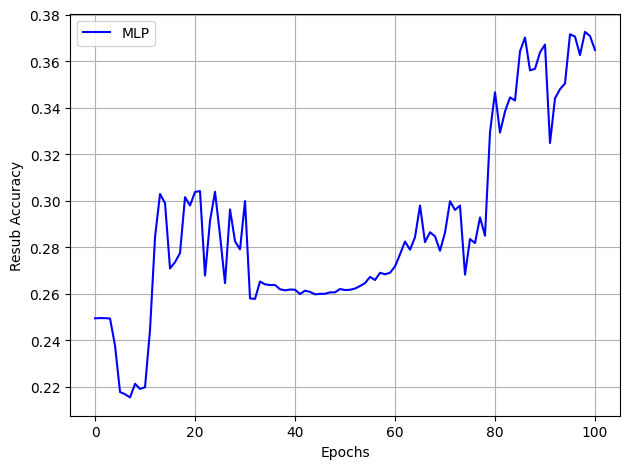

In [51]:
print_result(
    mlp,
    x_train.to_numpy(),
    y_train_cat.to_numpy(),
    x_test.to_numpy(),
    y_test_cat,
    "MLP",
    "blue",
)
plt.show()

ADD COMMENTARY

### Apply Normalization to Numeric Features and Retrain the MLP

In [29]:
scaler = StandardScaler().set_output(transform="pandas")
# Scale all features but State
x_train_scaled = x_train.drop(columns=["State"]).copy()
x_test_scaled = x_test.drop(columns=["State"]).copy()
# Fit scaler on training data
scaler.fit(x_train_scaled)
# Transform both training and test data
x_train_scaled = scaler.transform(x_train_scaled)
x_test_scaled = scaler.transform(x_test_scaled)
# Add back the State column
x_train_scaled["State"] = x_train["State"]
x_test_scaled["State"] = x_test["State"]


In [30]:
full_hyper_grid = {
    "eta": [0.000001, 0.00001],  # Learning rates
    "C": [0.0, 0.001, 0.01],  # Regularization strengths
    "n_hidden": [30, 50],  # Number of neurons in hidden layer
    "epochs": [500],  # Number of epochs
}

In [ ]:
# scaled_grid_results = grid_search(
#     nn=TLPBetterInitial,
#     x=x_train_scaled.to_numpy(),
#     y=y_train_cat.to_numpy(),
#     param_grid=full_hyper_grid,
# ).sort_values(by="accuracy_mean", ascending=False)

In [52]:
scaled_grid_results = pd.read_csv("scaled_grid_results.csv")
scaled_grid_results.head()
# scaled_grid_results.to_csv("scaled_grid_results.csv", index=False)

,eta,C,n_hidden,epochs,accuracy_mean,accuracy_std
0,0.000010,0.001,30,500,0.544247,0.015732
1,0.000010,0.001,30,500,0.542613,0.018852
2,0.000001,0.001,50,500,0.537199,0.008143
3,0.000001,0.001,50,500,0.533812,0.008549
4,0.000001,0.001,50,500,0.533709,0.014386


In [53]:
scaled_best_params = scaled_grid_results.iloc[0][:4]
scaled_best_params

eta           0.00001
C             0.00100
n_hidden     30.00000
epochs      500.00000
Name: 0, dtype: float64

In [54]:
scaled_mlp = TLPBetterInitial(
    eta=scaled_best_params["eta"],
    C=scaled_best_params["C"],
    n_hidden=int(scaled_best_params["n_hidden"]),
    epochs=int(scaled_best_params["epochs"]),
    random_state=7324,
)
# Fit the mlp to the scaled data
scaled_mlp.fit(
    x_train_scaled.to_numpy(), y_train_cat.to_numpy(), print_progress=10
)

Epoch: 500/500

In [55]:
# Check the accuracy of the mlp on the test set
yhat_scaled = scaled_mlp.predict(x_test_scaled.to_numpy())
accuracy_score(y_true=y_test_cat, y_pred=yhat_scaled)

0.5239273927392739

MLP w/ Scaling :
Resubstitution acc: 0.5233953312476364
Validation acc: 0.5239273927392739


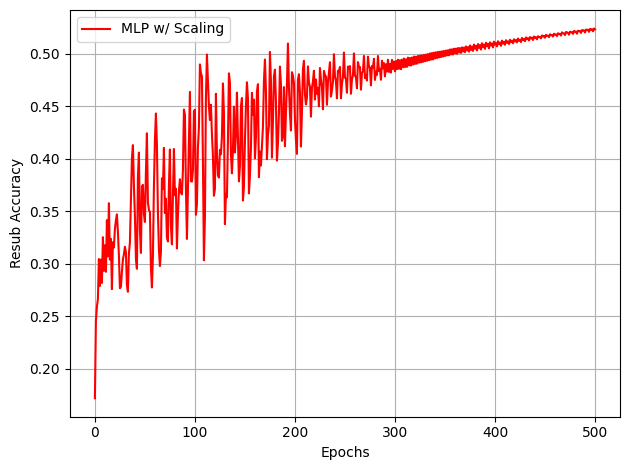

In [57]:
print_result(
    scaled_mlp,
    x_train_scaled.to_numpy(),
    y_train_cat.to_numpy(),
    x_test_scaled.to_numpy(),
    y_test_cat,
    "MLP w/ Scaling",
    "red",
)
plt.show()

ADD COMMENTARY

### Apply One-Hot Encoding to State Column and Retrain the MLP

In [58]:
encoder = OneHotEncoder(sparse_output=False).set_output(transform="pandas")
# Fit the encoder on the training data
encoder.fit(x_train_scaled[["State"]])
# Transform both training and test data
x_train_encoded = encoder.transform(x_train_scaled[["State"]])
x_test_encoded = encoder.transform(x_test_scaled[["State"]])
# Concatenate the encoded state columns with the rest of the features
x_train_final = pd.concat(
    [x_train_scaled.drop(columns=["State"]), x_train_encoded],
    axis=1,
)
x_test_final = pd.concat(
    [x_test_scaled.drop(columns=["State"]), x_test_encoded],
    axis=1,
)

In [67]:
# final_grid_results = grid_search(
#     nn=TLPBetterInitial,
#     x=x_train_final.to_numpy(),
#     y=y_train_cat.to_numpy(),
#     param_grid=full_hyper_grid,
# ).sort_values(by="accuracy_mean", ascending=False)
final_grid_results = pd.read_csv("final_two_layer_grid_results.csv")

In [68]:
# final_grid_results.to_csv("final_two_layer_grid_results.csv", index=False)
final_grid_results.head()

,eta,C,n_hidden,epochs,accuracy_mean,accuracy_std
0,0.00001,0.001,30,500,0.668030,0.005587
1,0.00001,0.001,50,500,0.666208,0.006738
2,0.00001,0.001,50,500,0.666122,0.003631
3,0.00001,0.001,50,500,0.662151,0.005439
4,0.00001,0.001,30,500,0.661894,0.007629


In [61]:
final_best_params = final_grid_results.iloc[0][:4]
final_best_params

eta           0.00001
C             0.00100
n_hidden     30.00000
epochs      500.00000
Name: 6, dtype: float64

In [75]:
# Initialize the final mlp with one-hot encoded state
final_mlp = TLPBetterInitial(
    eta=final_best_params["eta"],
    C=final_best_params["C"],
    n_hidden=int(final_best_params["n_hidden"]),
    epochs=1500,
    random_state=7324,
)
# Fit the final mlp to the one-hot encoded data
final_mlp.fit(
    x_train_final.to_numpy(), y_train_cat.to_numpy(), print_progress=10
)

Epoch: 1500/1500

In [76]:
# Check the accuracy of the new mlp on the test set
yhat_final = final_mlp.predict(x_test_final.to_numpy())
accuracy_score(y_true=y_test_cat, y_pred=yhat_final)

0.7238723872387238

MLP w/ Scaling :
Resubstitution acc: 0.7241723106542441
Validation acc: 0.7238723872387238


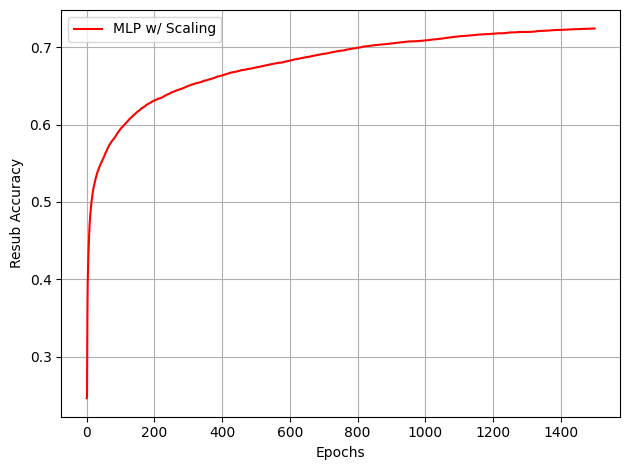

In [77]:
print_result(
    final_mlp,
    x_train_final.to_numpy(),
    y_train_cat.to_numpy(),
    x_test_final.to_numpy(),
    y_test_cat,
    "MLP w/ Scaling",
    "red",
)
plt.show()

ADD COMMENTARY

### Model Performance Comparison

In [86]:
# Run McNemar's test to compare the three classifiers
def mcnemar_test(y_true, y_pred1, y_pred2):
    """Perform McNemar's test to compare two classifiers."""
    # Create a contingency table
    contingency_table = pd.crosstab(y_pred1, y_pred2)
    # Perform McNemar's test
    result = mcnemar(contingency_table)
    return result.statistic, result.pvalue

In [87]:
# Initial model vs. model with scaling
mcnemar_test(y_true=y_test_cat, y_pred1=yhat, y_pred2=yhat_scaled)

(np.float64(0.0), np.float64(4.060706939705039e-115))

Due to the extremely low p-value, we reject the null hypothesis and conclude that the initial model and scaled model are significantly different.

In [88]:
# Scaled model vs. final two-layer model with one-hot encoding
mcnemar_test(y_true=y_test_cat, y_pred1=yhat_scaled, y_pred2=yhat_final)

(np.float64(385.0), np.float64(1.7858051209571057e-18))

Due to the extremely low p-value, we reject the null hypothesis and conclude that the scaled model and one-hot encoded model are significantly different.

From these tests, we can see that both scaling and one-hot encoding have a significant impact on the model's performance. The scaled model performs better than the initial model, and the one-hot encoded model performs better than the scaled model. This suggests that both scaling and one-hot encoding are important preprocessing steps for this dataset.

This is the expected result, as scaling the numeric features removes any variance due to the scale of the numeric features, which helps the model to converge more quickly. One-hot encoding the state column allows this categorical feature to be used in the model, which can provide additional information for the model to learn from.

## Modeling

In [ ]:
class ThreeLayerPerceptronBase(object):
    def __init__(
        self,
        n_hidden=20,
        n_hidden1=30,
        C=0.0,
        epochs=500,
        eta=0.00001,
        random_state=None,
    ):
        np.random.seed(random_state)
        self.n_hidden = n_hidden
        self.n_hidden1 = n_hidden1
        self.l2_C = C
        self.epochs = epochs
        self.eta = eta

    @staticmethod
    def _encode_labels(y):
        """Encode labels into one-hot representation"""
        onehot = pd.get_dummies(y).values.T

        return onehot

    def _initialize_weights(self):
        """Initialize weights with small random numbers."""
        W1_num_elems = (self.n_features_) * self.n_hidden
        W1 = np.random.uniform(-1.0, 1.0, size=W1_num_elems)
        W1 = W1.reshape(self.n_hidden, self.n_features_)  # reshape to be W
        b1 = np.zeros((self.n_hidden, 1))

        W2_num_elems = (self.n_features_) * self.n_hidden1
        W2 = np.random.uniform(-1.0, 1.0, size=W2_num_elems)
        W2 = W2.reshape(self.n_hidden1, self.n_features_)
        b2 = np.zeros((self.n_hidden1, 1))

        W3_num_elems = (self.n_hidden1) * self.n_output_
        W3 = np.random.uniform(-1.0, 1.0, size=W3_num_elems)
        W3 = W3.reshape(self.n_output_, self.n_hidden1)
        b3 = np.zeros((self.n_output_, 1))

        return W1, W2, W3, b1, b2, b3

    @staticmethod
    def _sigmoid(z):
        """Use scipy.special.expit to avoid overflow"""
        # 1.0 / (1.0 + np.exp(-z))
        return expit(z)

    @staticmethod
    def _L2_reg(lambda_, W1, W2, W3):
        """Compute L2-regularization cost"""
        # only compute for non-bias terms
        return (lambda_ / 3.0) * np.sqrt(
            np.mean(W1[:, 1:] ** 2)
            + np.mean(W2[:, 1:] ** 2)
            + (np.mean(W3[:, 1:] ** 2))
        )

    def _cost(self, A3, Y_enc, W1, W2, W3):
        """Get the objective function value"""
        cost = np.mean((Y_enc - A3) ** 2)
        L2_term = self._L2_reg(self.l2_C, W1, W2, W3)
        return cost + L2_term

    def _feedforward(self, X, W1, W2, W3, b1, b2, b3):
        """Compute feedforward step.

        -----------
        X : Input layer with original features.
        W1: Weight matrix for input layer -> hidden layer.
        W2: Weight matrix for hidden layer -> output layer.
        ----------
        a1-a3 : activations into layer (or output layer)
        z1-z2 : layer inputs

        """
        A1 = X.T
        Z1 = W1 @ A1 + b1
        A2 = self._sigmoid(Z1)
        Z2 = W2 @ A2 + b2
        A3 = self._sigmoid(Z2)
        Z3 = W3 @ A3 + b3
        A4 = self._sigmoid(Z3)
        return A1, Z1, A2, Z2, A3, Z3, A4

    def _get_gradient(self, A1, A2, A3, A4, Z1, Z2, Z3, Y_enc, W1, W2, W3):
        """Compute gradient step using backpropagation."""
        # vectorized backpropagation
        # This uses MSE as cost function
        V3 = -2 * (Y_enc - A4) * A4 * (1 - A4)
        V2 = -2 * (Y_enc - A3) * A3 * (1 - A3)
        V1 = A2 * (1 - A2) * (W2.T @ V2)

        gradW3 = V3 @ A3.T
        gradW2 = V2 @ A2.T
        gradW1 = V1 @ A1.T

        gradb3 = np.sum(V3, axis=1).reshape((-1, 1))
        gradb2 = np.sum(V2, axis=1).reshape((-1, 1))
        gradb1 = np.sum(V1, axis=1).reshape((-1, 1))

        # regularize weights that are not bias terms
        gradW1 += W1 * self.l2_C
        gradW2 += W2 * self.l2_C
        gradW3 += W3 * self.l2_C

        return gradW1, gradW2, gradW3, gradb1, gradb2, gradb3

    def predict(self, X):
        """Predict class labels."""
        _, _, _, _, _, _, A4 = self._feedforward(
            X, self.W1, self.W2, self.W3, self.b1, self.b2, self.b3
        )
        y_pred = np.argmax(A4, axis=0)
        return y_pred

In [ ]:
class ThreeLPMiniBatch(ThreeLayerPerceptronBase):
    def __init__(
        self,
        shuffle=True,
        minibatches=1,
        **kwds,
    ):
        # need to add to the original initializer
        self.shuffle = shuffle
        self.minibatches = minibatches
        # but keep other keywords
        super().__init__(**kwds)

    def fit(self, X, y, print_progress=False, XY_test=None):
        """Learn weights from training data. With mini-batch"""
        X_data, y_data = X.copy(), y.copy()
        Y_enc = self._encode_labels(y)

        # init weights and setup matrices
        self.n_features_ = X_data.shape[1]
        self.n_output_ = Y_enc.shape[0]
        self.W1, self.W2, self.W3, self.b1, self.b2, self.b3 = (
            self._initialize_weights()
        )
        self.cost_ = []
        self.score_ = []
        # get starting acc
        self.score_.append(accuracy_score(y_data, self.predict(X_data)))
        # keep track of validation, if given
        if XY_test is not None:
            X_test = XY_test[0].copy()
            y_test = XY_test[1].copy()
            self.val_score_ = []
            self.val_score_.append(
                accuracy_score(y_test, self.predict(X_test))
            )
            self.val_cost_ = []

        for i in range(self.epochs):
            if print_progress > 0 and (i + 1) % print_progress == 0:
                sys.stderr.write("\rEpoch: %d/%d" % (i + 1, self.epochs))
                sys.stderr.flush()

            if self.shuffle:
                idx_shuffle = np.random.permutation(y_data.shape[0])
                X_data, Y_enc, y_data = (
                    X_data[idx_shuffle],
                    Y_enc[:, idx_shuffle],
                    y_data[idx_shuffle],
                )

            mini = np.array_split(range(y_data.shape[0]), self.minibatches)
            mini_cost = []
            for idx in mini:
                # feedforward
                A1, Z1, A2, Z2, A3, Z3, A4 = self._feedforward(
                    X_data[idx],
                    self.W1,
                    self.W2,
                    self.W3,
                    self.b1,
                    self.b2,
                    self.b3,
                )

                cost = self._cost(
                    A4, Y_enc[:, idx], self.W1, self.W2, self.W3
                )
                mini_cost.append(
                    cost
                )  # this appends cost of mini-batch only

                # compute gradient via backpropagation
                gradW1, gradW2, gradW3, gradb1, gradb2, gradb3 = (
                    self._get_gradient(
                        A1=A1,
                        A2=A2,
                        A3=A3,
                        A4=A4,
                        Z1=Z1,
                        Z2=Z2,
                        Z3=Z3,
                        Y_enc=Y_enc[:, idx],
                        W1=self.W1,
                        W2=self.W2,
                        W3=self.W3,
                    )
                )

                # uUdate weights and biases
                rho_W1, rho_W2, rho_W3 = (
                    self.eta * gradW1,
                    self.eta * gradW2,
                    self.eta * gradW3,
                )
                self.W1 -= rho_W1
                self.W2 -= rho_W2
                self.W3 -= rho_W3
                self.b1 -= self.eta * gradb1
                self.b2 -= self.eta * gradb2
                self.b3 -= self.eta * gradb3

            self.cost_.append(np.mean(mini_cost))
            self.score_.append(
                accuracy_score(y_data, self.predict(X_data))
            )

            # update if a validation set was provided
            if XY_test is not None:
                yhat = self.predict(X_test)
                self.val_score_.append(accuracy_score(y_test, yhat))

        return self

In [91]:
class ThreeLPMiniBatchCrossEntropy(ThreeLPMiniBatch):
    def _cost(self, A4, Y_enc, W1, W2, W3):
        """Get the objective function value"""
        cost = -np.mean(
            np.nan_to_num(
                (
                    Y_enc * np.log(A4 + 1e-7)
                    + (1 - Y_enc) * np.log(1 - A4 + 1e-7)
                )
            )
        )
        L2_term = self._L2_reg(self.l2_C, W1, W2, W3)
        return cost + L2_term

    def _get_gradient(self, A1, A2, A3, A4, Z1, Z2, Z3, Y_enc, W1, W2, W3):
        """Compute gradient step using backpropagation."""
        # vectorized backpropagation
        # Now using cross-entropy as cost function
        V3 = A4 - Y_enc
        V2 = A3 * (1 - A3) * (W3.T @ V3)
        V1 = A2 * (1 - A2) * (W2.T @ V2)

        gradW3 = V3 @ A3.T
        gradW2 = V2 @ A2.T
        gradW1 = V1 @ A1.T

        gradb3 = np.sum(V3, axis=1).reshape((-1, 1))
        gradb2 = np.sum(V2, axis=1).reshape((-1, 1))
        gradb1 = np.sum(V1, axis=1).reshape((-1, 1))

        # regularize weights that are not bias terms
        gradW1 += W1 * self.l2_C
        gradW2 += W2 * self.l2_C
        gradW3 += W3 * self.l2_C

        return gradW1, gradW2, gradW3, gradb1, gradb2, gradb3

In [92]:
class ThreeLPBetterInitial(ThreeLPMiniBatchCrossEntropy):
    def _initialize_weights(self):
        """Initialize weights Glorot and He normalization."""
        init_bound = 4 * np.sqrt(6.0 / (self.n_hidden + self.n_features_))
        W1 = np.random.uniform(
            -init_bound, init_bound, (self.n_hidden, self.n_features_)
        )

        # reduce the final layer magnitude in order to balance the size of the gradients
        # between
        init_bound = 4 * np.sqrt(6 / (self.n_hidden1 + self.n_features_))
        W2 = np.random.uniform(
            -init_bound, init_bound, (self.n_hidden1, self.n_hidden)
        )
        # reduce the final layer magnitude in order to balance the size of the gradients
        # between
        init_bound = 4 * np.sqrt(6 / (self.n_output_ + self.n_hidden1))
        W3 = np.random.uniform(
            -init_bound, init_bound, (self.n_output_, self.n_hidden1)
        )

        # set these to zero to start so that
        # they do not immediately saturate the neurons
        b1 = np.zeros((self.n_hidden, 1))
        b2 = np.zeros((self.n_hidden1, 1))
        b3 = np.zeros((self.n_output_, 1))

        return W1, W2, W3, b1, b2, b3

In [ ]:
# Initialize the mlp
mlp = ThreeLPBetterInitial(random_state=7324, epochs=800)
# Fit the mlp
mlp.fit(
    x_train_final.to_numpy(), y_train_cat.to_numpy(), print_progress=10
)

Epoch: 800/800

In [94]:
# Check the accuracy of the mlp on the test set
yhat = mlp.predict(x_test_final.to_numpy())
accuracy_score(y_true=y_test_cat, y_pred=yhat)

0.7234598459845984

In [95]:
def print_result(
    nn, X_train, y_train, X_test, y_test, title="", color="red"
):
    print("=================")
    print(title, ":")
    yhat = nn.predict(X_train)
    print("Resubstitution acc:", accuracy_score(y_train, yhat))

    yhat = nn.predict(X_test)
    print("Validation acc:", accuracy_score(y_test, yhat))

    if hasattr(nn, "val_score_"):
        plt.plot(
            range(len(nn.val_score_)),
            nn.val_score_,
            color=color,
            label=title,
        )
        plt.ylabel("Validation Accuracy")
    else:
        plt.plot(
            range(len(nn.score_)), nn.score_, color=color, label=title
        )
        plt.ylabel("Resub Accuracy")

    plt.xlabel("Epochs")
    plt.tight_layout()
    plt.legend(loc="best")
    plt.grid(True)

MLP w/ Scaling :
Resubstitution acc: 0.7212672327844054
Validation acc: 0.7234598459845984


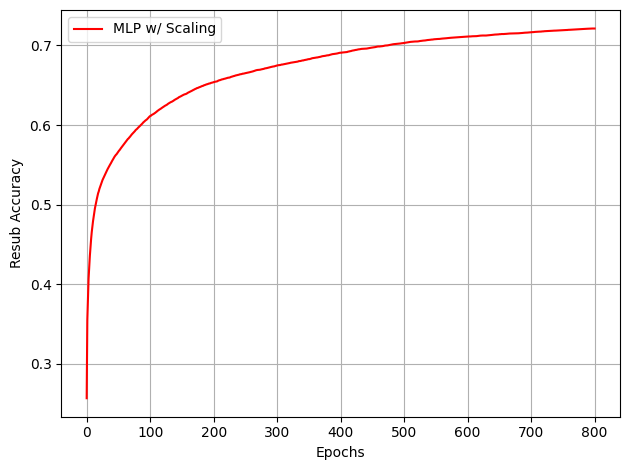

In [96]:
print_result(
    mlp,
    x_train_final.to_numpy(),
    y_train_cat.to_numpy(),
    x_test_final.to_numpy(),
    y_test_cat,
    "MLP w/ Scaling",
    "red",
)
plt.show()

In [ ]:
class FourLayerPerceptronBase(object):
    def __init__(
        self,
        n_hidden=30,
        n_hidden1=20,
        n_hidden2=10,
        C=0.0,
        epochs=500,
        eta=0.00001,
        random_state=None,
    ):
        np.random.seed(random_state)
        self.n_hidden = n_hidden
        self.n_hidden1 = n_hidden1
        self.n_hidden2 = n_hidden2
        self.l2_C = C
        self.epochs = epochs
        self.eta = eta

    @staticmethod
    def _encode_labels(y):
        """Encode labels into one-hot representation"""
        onehot = pd.get_dummies(y).values.T

        return onehot

    def _initialize_weights(self):
        """Initialize weights with small random numbers."""
        W1_num_elems = (self.n_features_) * self.n_hidden
        W1 = np.random.uniform(-1.0, 1.0, size=W1_num_elems)
        W1 = W1.reshape(self.n_hidden, self.n_features_)  # reshape to be W
        b1 = np.zeros((self.n_hidden, 1))

        W2_num_elems = (self.n_features_) * self.n_hidden1
        W2 = np.random.uniform(-1.0, 1.0, size=W2_num_elems)
        W2 = W2.reshape(self.n_hidden1, self.n_features_)
        b2 = np.zeros((self.n_hidden1, 1))

        W3_num_elems = (self.n_features_) * self.n_hidden2
        W3 = np.random.uniform(-1.0, 1.0, size=W3_num_elems)
        W3 = W3.reshape(self.n_hidden2, self.n_features_)
        b3 = np.zeros((self.n_hidden2, 1))

        W4_num_elems = (self.n_hidden2) * self.n_output_
        W4 = np.random.uniform(-1.0, 1.0, size=W4_num_elems)
        W4 = W4.reshape(self.n_output_, self.n_hidden2)
        b4 = np.zeros((self.n_output_, 1))

        return W1, W2, W3, W4, b1, b2, b3, b4

    @staticmethod
    def _sigmoid(z):
        """Use scipy.special.expit to avoid overflow"""
        # 1.0 / (1.0 + np.exp(-z))
        return expit(z)

    @staticmethod
    def _L2_reg(lambda_, W1, W2, W3, W4):
        """Compute L2-regularization cost"""
        # only compute for non-bias terms
        return (lambda_ / 4.0) * np.sqrt(
            np.mean(W1[:, 1:] ** 2)
            + np.mean(W2[:, 1:] ** 2)
            + np.mean(W3[:, 1:] ** 2)
            + np.mean(W4[:, 1:] ** 2)
        )

    def _cost(self, A4, Y_enc, W1, W2, W3, W4):
        """Get the objective function value"""
        cost = np.mean((Y_enc - A4) ** 2)
        L2_term = self._L2_reg(self.l2_C, W1, W2, W3, W4)
        return cost + L2_term

    def _feedforward(self, X, W1, W2, W3, W4, b1, b2, b3, b4):
        """Compute feedforward step.

        -----------
        X : Input layer with original features.
        W1: Weight matrix for input layer -> hidden layer.
        W2: Weight matrix for hidden layer -> output layer.
        ----------
        a1-a3 : activations into layer (or output layer)
        z1-z2 : layer inputs

        """
        A1 = X.T
        Z1 = W1 @ A1 + b1
        A2 = self._sigmoid(Z1)
        Z2 = W2 @ A2 + b2
        A3 = self._sigmoid(Z2)
        Z3 = W3 @ A3 + b3
        A4 = self._sigmoid(Z3)
        Z4 = W4 @ A4 + b4
        A5 = self._sigmoid(Z4)
        return A1, Z1, A2, Z2, A3, Z3, A4, Z4, A5

    def _get_gradient(
        self, A1, A2, A3, A4, A5, Z1, Z2, Z3, Z4, Y_enc, W1, W2, W3, W4
    ):
        """Compute gradient step using backpropagation."""
        # vectorized backpropagation
        # This uses MSE as cost function
        V4 = -2 * (Y_enc - A5) * A5 * (1 - A5)
        V3 = -2 * (Y_enc - A4) * A4 * (1 - A4)
        V2 = -2 * (Y_enc - A3) * A3 * (1 - A3)
        V1 = A2 * (1 - A2) * (W2.T @ V2)

        gradW4 = V4 @ A4.T
        gradW3 = V3 @ A3.T
        gradW2 = V2 @ A2.T
        gradW1 = V1 @ A1.T

        gradb4 = np.sum(V4, axis=1).reshape((-1, 1))
        gradb3 = np.sum(V3, axis=1).reshape((-1, 1))
        gradb2 = np.sum(V2, axis=1).reshape((-1, 1))
        gradb1 = np.sum(V1, axis=1).reshape((-1, 1))

        # regularize weights that are not bias terms
        gradW1 += W1 * self.l2_C
        gradW2 += W2 * self.l2_C
        gradW3 += W3 * self.l2_C
        gradW4 += W4 * self.l2_C

        return (
            gradW1,
            gradW2,
            gradW3,
            gradW4,
            gradb1,
            gradb2,
            gradb3,
            gradb4,
        )

    def predict(self, X):
        """Predict class labels."""
        _, _, _, _, _, _, _, _, A5 = self._feedforward(
            X,
            self.W1,
            self.W2,
            self.W3,
            self.W4,
            self.b1,
            self.b2,
            self.b3,
            self.b4,
        )
        y_pred = np.argmax(A5, axis=0)
        return y_pred

In [ ]:
class FourLPMiniBatch(FourLayerPerceptronBase):
    def __init__(
        self,
        shuffle=True,
        minibatches=1,
        **kwds,
    ):
        # need to add to the original initializer
        self.shuffle = shuffle
        self.minibatches = minibatches
        # but keep other keywords
        super().__init__(**kwds)

    def fit(self, X, y, print_progress=False, XY_test=None):
        """Learn weights from training data. With mini-batch"""
        X_data, y_data = X.copy(), y.copy()
        Y_enc = self._encode_labels(y)

        # init weights and setup matrices
        self.n_features_ = X_data.shape[1]
        self.n_output_ = Y_enc.shape[0]
        (
            self.W1,
            self.W2,
            self.W3,
            self.W4,
            self.b1,
            self.b2,
            self.b3,
            self.b4,
        ) = self._initialize_weights()
        self.cost_ = []
        self.score_ = []
        # get starting acc
        self.score_.append(accuracy_score(y_data, self.predict(X_data)))
        # keep track of validation, if given
        if XY_test is not None:
            X_test = XY_test[0].copy()
            y_test = XY_test[1].copy()
            self.val_score_ = []
            self.val_score_.append(
                accuracy_score(y_test, self.predict(X_test))
            )
            self.val_cost_ = []

        for i in range(self.epochs):
            if print_progress > 0 and (i + 1) % print_progress == 0:
                sys.stderr.write("\rEpoch: %d/%d" % (i + 1, self.epochs))
                sys.stderr.flush()

            if self.shuffle:
                idx_shuffle = np.random.permutation(y_data.shape[0])
                X_data, Y_enc, y_data = (
                    X_data[idx_shuffle],
                    Y_enc[:, idx_shuffle],
                    y_data[idx_shuffle],
                )

            mini = np.array_split(range(y_data.shape[0]), self.minibatches)
            mini_cost = []
            for idx in mini:
                # feedforward
                A1, Z1, A2, Z2, A3, Z3, A4, Z4, A5 = self._feedforward(
                    X_data[idx],
                    self.W1,
                    self.W2,
                    self.W3,
                    self.W4,
                    self.b1,
                    self.b2,
                    self.b3,
                    self.b4,
                )

                cost = self._cost(
                    A5, Y_enc[:, idx], self.W1, self.W2, self.W3, self.W4
                )
                mini_cost.append(
                    cost
                )  # this appends cost of mini-batch only

                # compute gradient via backpropagation
                (
                    gradW1,
                    gradW2,
                    gradW3,
                    gradW4,
                    gradb1,
                    gradb2,
                    gradb3,
                    gradb4,
                ) = self._get_gradient(
                    A1=A1,
                    A2=A2,
                    A3=A3,
                    A4=A4,
                    A5=A5,
                    Z1=Z1,
                    Z2=Z2,
                    Z3=Z3,
                    Z4=Z4,
                    Y_enc=Y_enc[:, idx],
                    W1=self.W1,
                    W2=self.W2,
                    W3=self.W3,
                    W4=self.W4,
                )

                # uUdate weights and biases
                rho_W1, rho_W2, rho_W3, rho_W4 = (
                    self.eta * gradW1,
                    self.eta * gradW2,
                    self.eta * gradW3,
                    self.eta * gradW4,
                )
                self.W1 -= rho_W1
                self.W2 -= rho_W2
                self.W3 -= rho_W3
                self.W4 -= rho_W4
                self.b1 -= self.eta * gradb1
                self.b2 -= self.eta * gradb2
                self.b3 -= self.eta * gradb3
                self.b4 -= self.eta * gradb4

            self.cost_.append(np.mean(mini_cost))
            self.score_.append(
                accuracy_score(y_data, self.predict(X_data))
            )

            # update if a validation set was provided
            if XY_test is not None:
                yhat = self.predict(X_test)
                self.val_score_.append(accuracy_score(y_test, yhat))

        return self

In [ ]:
class FourLPMiniBatchCrossEntropy(FourLPMiniBatch):
    def _cost(self, A5, Y_enc, W1, W2, W3, W4):
        """Get the objective function value"""
        cost = -np.mean(
            np.nan_to_num(
                (
                    Y_enc * np.log(A5 + 1e-7)
                    + (1 - Y_enc) * np.log(1 - A5 + 1e-7)
                )
            )
        )
        L2_term = self._L2_reg(self.l2_C, W1, W2, W3, W4)
        return cost + L2_term

    def _get_gradient(
        self, A1, A2, A3, A4, A5, Z1, Z2, Z3, Z4, Y_enc, W1, W2, W3, W4
    ):
        """Compute gradient step using backpropagation."""
        # vectorized backpropagation
        # Now using cross-entropy as cost function
        V4 = A5 - Y_enc
        V3 = A4 * (1 - A4) * (W4.T @ V4)
        V2 = A3 * (1 - A3) * (W3.T @ V3)
        V1 = A2 * (1 - A2) * (W2.T @ V2)

        gradW4 = V4 @ A4.T
        gradW3 = V3 @ A3.T
        gradW2 = V2 @ A2.T
        gradW1 = V1 @ A1.T

        gradb4 = np.sum(V4, axis=1).reshape((-1, 1))
        gradb3 = np.sum(V3, axis=1).reshape((-1, 1))
        gradb2 = np.sum(V2, axis=1).reshape((-1, 1))
        gradb1 = np.sum(V1, axis=1).reshape((-1, 1))

        # regularize weights that are not bias terms
        gradW1 += W1 * self.l2_C
        gradW2 += W2 * self.l2_C
        gradW3 += W3 * self.l2_C
        gradW4 += W4 * self.l2_C

        return (
            gradW1,
            gradW2,
            gradW3,
            gradW4,
            gradb1,
            gradb2,
            gradb3,
            gradb4,
        )

In [ ]:
class FourLPBetterInitial(FourLPMiniBatchCrossEntropy):
    def _initialize_weights(self):
        """Initialize weights Glorot and He normalization."""
        init_bound = 4 * np.sqrt(6.0 / (self.n_hidden + self.n_features_))
        W1 = np.random.uniform(
            -init_bound, init_bound, (self.n_hidden, self.n_features_)
        )

        # reduce the final layer magnitude in order to balance the size of the gradients
        # between
        init_bound = 4 * np.sqrt(6 / (self.n_hidden1 + self.n_features_))
        W2 = np.random.uniform(
            -init_bound, init_bound, (self.n_hidden1, self.n_hidden)
        )
        # reduce the final layer magnitude in order to balance the size of the gradients
        # between
        init_bound = 4 * np.sqrt(6 / (self.n_hidden2 + self.n_features_))
        W3 = np.random.uniform(
            -init_bound, init_bound, (self.n_hidden2, self.n_hidden1)
        )

        # reduce the final layer magnitude in order to balance the size of the gradients
        # between
        init_bound = 4 * np.sqrt(6 / (self.n_output_ + self.n_hidden2))
        W4 = np.random.uniform(
            -init_bound, init_bound, (self.n_output_, self.n_hidden2)
        )

        # set these to zero to start so that
        # they do not immediately saturate the neurons
        b1 = np.zeros((self.n_hidden, 1))
        b2 = np.zeros((self.n_hidden1, 1))
        b3 = np.zeros((self.n_hidden2, 1))
        b4 = np.zeros((self.n_output_, 1))

        return W1, W2, W3, W4, b1, b2, b3, b4

In [ ]:
# Initialize the mlp
mlp = FourLPBetterInitial(random_state=7324, epochs=800)
# Fit the mlp
mlp.fit(
    x_train_final.to_numpy(), y_train_cat.to_numpy(), print_progress=10
)

Epoch: 800/800

In [102]:
# Check the accuracy of the mlp on the test set
yhat = mlp.predict(x_test_final.to_numpy())
accuracy_score(y_true=y_test_cat, y_pred=yhat)

0.7253162816281629

In [103]:
def print_result(
    nn, X_train, y_train, X_test, y_test, title="", color="red"
):
    print("=================")
    print(title, ":")
    yhat = nn.predict(X_train)
    print("Resubstitution acc:", accuracy_score(y_train, yhat))

    yhat = nn.predict(X_test)
    print("Validation acc:", accuracy_score(y_test, yhat))

    if hasattr(nn, "val_score_"):
        plt.plot(
            range(len(nn.val_score_)),
            nn.val_score_,
            color=color,
            label=title,
        )
        plt.ylabel("Validation Accuracy")
    else:
        plt.plot(
            range(len(nn.score_)), nn.score_, color=color, label=title
        )
        plt.ylabel("Resub Accuracy")

    plt.xlabel("Epochs")
    plt.tight_layout()
    plt.legend(loc="best")
    plt.grid(True)

MLP w/ Scaling :
Resubstitution acc: 0.7232612507305669
Validation acc: 0.7253162816281629


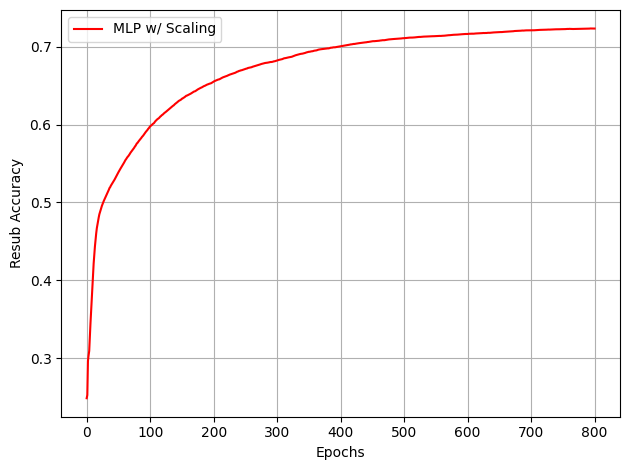

In [104]:
print_result(
    mlp,
    x_train_final.to_numpy(),
    y_train_cat.to_numpy(),
    x_test_final.to_numpy(),
    y_test_cat,
    "MLP w/ Scaling",
    "red",
)
plt.show()

In [ ]:
class FiveLayerPerceptronBase(object):
    def __init__(
        self,
        n_hidden=30,
        n_hidden1=20,
        n_hidden2=10,
        n_hidden3=5,
        C=0.0,
        epochs=500,
        eta=0.00001,
        random_state=None,
    ):
        np.random.seed(random_state)
        self.n_hidden = n_hidden
        self.n_hidden1 = n_hidden1
        self.n_hidden2 = n_hidden2
        self.n_hidden3 = n_hidden3
        self.l2_C = C
        self.epochs = epochs
        self.eta = eta

    @staticmethod
    def _encode_labels(y):
        """Encode labels into one-hot representation"""
        onehot = pd.get_dummies(y).values.T

        return onehot

    def _initialize_weights(self):
        """Initialize weights with small random numbers."""
        W1_num_elems = (self.n_features_) * self.n_hidden
        W1 = np.random.uniform(-1.0, 1.0, size=W1_num_elems)
        W1 = W1.reshape(self.n_hidden, self.n_features_)  # reshape to be W
        b1 = np.zeros((self.n_hidden, 1))

        W2_num_elems = (self.n_features_) * self.n_hidden1
        W2 = np.random.uniform(-1.0, 1.0, size=W2_num_elems)
        W2 = W2.reshape(self.n_hidden1, self.n_features_)
        b2 = np.zeros((self.n_hidden1, 1))

        W3_num_elems = (self.n_features_) * self.n_hidden2
        W3 = np.random.uniform(-1.0, 1.0, size=W3_num_elems)
        W3 = W3.reshape(self.n_hidden2, self.n_features_)
        b3 = np.zeros((self.n_hidden2, 1))

        W4_num_elems = (self.n_features_) * self.n_hidden3
        W4 = np.random.uniform(-1.0, 1.0, size=W4_num_elems)
        W4 = W4.reshape(self.n_hidden3, self.n_features_)
        b4 = np.zeros((self.n_hidden3, 1))

        W5_num_elems = (self.n_hidden3) * self.n_output_
        W5 = np.random.uniform(-1.0, 1.0, size=W5_num_elems)
        W5 = W5.reshape(self.n_output_, self.n_hidden3)
        b5 = np.zeros((self.n_output_, 1))

        return W1, W2, W3, W4, W5, b1, b2, b3, b4, b5

    @staticmethod
    def _sigmoid(z):
        """Use scipy.special.expit to avoid overflow"""
        # 1.0 / (1.0 + np.exp(-z))
        return expit(z)

    @staticmethod
    def _L2_reg(lambda_, W1, W2, W3, W4, W5):
        """Compute L2-regularization cost"""
        # only compute for non-bias terms
        return (lambda_ / 5.0) * np.sqrt(
            np.mean(W1[:, 1:] ** 2)
            + np.mean(W2[:, 1:] ** 2)
            + np.mean(W3[:, 1:] ** 2)
            + np.mean(W4[:, 1:] ** 2)
            + np.mean(W5[:, 1:] ** 2)
        )

    def _cost(self, A5, Y_enc, W1, W2, W3, W4, W5):
        """Get the objective function value"""
        cost = np.mean((Y_enc - A5) ** 2)
        L2_term = self._L2_reg(self.l2_C, W1, W2, W3, W4, W5)
        return cost + L2_term

    def _feedforward(self, X, W1, W2, W3, W4, W5, b1, b2, b3, b4, b5):
        """Compute feedforward step.

        -----------
        X : Input layer with original features.
        W1: Weight matrix for input layer -> hidden layer.
        W2: Weight matrix for hidden layer -> output layer.
        ----------
        a1-a3 : activations into layer (or output layer)
        z1-z2 : layer inputs

        """
        A1 = X.T
        Z1 = W1 @ A1 + b1
        A2 = self._sigmoid(Z1)
        Z2 = W2 @ A2 + b2
        A3 = self._sigmoid(Z2)
        Z3 = W3 @ A3 + b3
        A4 = self._sigmoid(Z3)
        Z4 = W4 @ A4 + b4
        A5 = self._sigmoid(Z4)
        Z5 = W5 @ A5 + b5
        A6 = self._sigmoid(Z5)
        return A1, Z1, A2, Z2, A3, Z3, A4, Z4, A5, Z5, A6

    def _get_gradient(
        self,
        A1,
        A2,
        A3,
        A4,
        A5,
        A6,
        Z1,
        Z2,
        Z3,
        Z4,
        Z5,
        Y_enc,
        W1,
        W2,
        W3,
        W4,
        W5,
    ):
        """Compute gradient step using backpropagation."""
        # vectorized backpropagation
        # This uses MSE as cost function
        V5 = -2 * (Y_enc - A6) * A6 * (1 - A6)
        V4 = -2 * (Y_enc - A5) * A5 * (1 - A5)
        V3 = -2 * (Y_enc - A4) * A4 * (1 - A4)
        V2 = -2 * (Y_enc - A3) * A3 * (1 - A3)
        V1 = A2 * (1 - A2) * (W2.T @ V2)

        gradW5 = V5 @ A5.T
        gradW4 = V4 @ A4.T
        gradW3 = V3 @ A3.T
        gradW2 = V2 @ A2.T
        gradW1 = V1 @ A1.T

        gradb5 = np.sum(V5, axis=1).reshape((-1, 1))
        gradb4 = np.sum(V4, axis=1).reshape((-1, 1))
        gradb3 = np.sum(V3, axis=1).reshape((-1, 1))
        gradb2 = np.sum(V2, axis=1).reshape((-1, 1))
        gradb1 = np.sum(V1, axis=1).reshape((-1, 1))

        # regularize weights that are not bias terms
        gradW1 += W1 * self.l2_C
        gradW2 += W2 * self.l2_C
        gradW3 += W3 * self.l2_C
        gradW4 += W4 * self.l2_C
        gradW5 += W5 * self.l2_C

        return (
            gradW1,
            gradW2,
            gradW3,
            gradW4,
            gradW5,
            gradb1,
            gradb2,
            gradb3,
            gradb4,
            gradb5,
        )

    def predict(self, X):
        """Predict class labels."""
        _, _, _, _, _, _, _, _, _, _, A6 = self._feedforward(
            X,
            self.W1,
            self.W2,
            self.W3,
            self.W4,
            self.W5,
            self.b1,
            self.b2,
            self.b3,
            self.b4,
            self.b5,
        )
        y_pred = np.argmax(A6, axis=0)
        return y_pred

In [ ]:
class FiveLPMiniBatch(FiveLayerPerceptronBase):
    def __init__(
        self,
        shuffle=True,
        minibatches=1,
        **kwds,
    ):
        # need to add to the original initializer
        self.shuffle = shuffle
        self.minibatches = minibatches
        # but keep other keywords
        super().__init__(**kwds)

    def fit(self, X, y, print_progress=False, XY_test=None):
        """Learn weights from training data. With mini-batch"""
        X_data, y_data = X.copy(), y.copy()
        Y_enc = self._encode_labels(y)

        # init weights and setup matrices
        self.n_features_ = X_data.shape[1]
        self.n_output_ = Y_enc.shape[0]
        (
            self.W1,
            self.W2,
            self.W3,
            self.W4,
            self.W5,
            self.b1,
            self.b2,
            self.b3,
            self.b4,
            self.b5,
        ) = self._initialize_weights()
        self.cost_ = []
        self.score_ = []
        # get starting acc
        self.score_.append(accuracy_score(y_data, self.predict(X_data)))
        # keep track of validation, if given
        if XY_test is not None:
            X_test = XY_test[0].copy()
            y_test = XY_test[1].copy()
            self.val_score_ = []
            self.val_score_.append(
                accuracy_score(y_test, self.predict(X_test))
            )
            self.val_cost_ = []

        for i in range(self.epochs):
            if print_progress > 0 and (i + 1) % print_progress == 0:
                sys.stderr.write("\rEpoch: %d/%d" % (i + 1, self.epochs))
                sys.stderr.flush()

            if self.shuffle:
                idx_shuffle = np.random.permutation(y_data.shape[0])
                X_data, Y_enc, y_data = (
                    X_data[idx_shuffle],
                    Y_enc[:, idx_shuffle],
                    y_data[idx_shuffle],
                )

            mini = np.array_split(range(y_data.shape[0]), self.minibatches)
            mini_cost = []
            for idx in mini:
                # feedforward
                A1, Z1, A2, Z2, A3, Z3, A4, Z4, A5, Z5, A6 = (
                    self._feedforward(
                        X_data[idx],
                        self.W1,
                        self.W2,
                        self.W3,
                        self.W4,
                        self.W5,
                        self.b1,
                        self.b2,
                        self.b3,
                        self.b4,
                        self.b5,
                    )
                )

                cost = self._cost(
                    A6,
                    Y_enc[:, idx],
                    self.W1,
                    self.W2,
                    self.W3,
                    self.W4,
                    self.W5,
                )
                mini_cost.append(
                    cost
                )  # this appends cost of mini-batch only

                # compute gradient via backpropagation
                (
                    gradW1,
                    gradW2,
                    gradW3,
                    gradW4,
                    gradW5,
                    gradb1,
                    gradb2,
                    gradb3,
                    gradb4,
                    gradb5,
                ) = self._get_gradient(
                    A1=A1,
                    A2=A2,
                    A3=A3,
                    A4=A4,
                    A5=A5,
                    A6=A6,
                    Z1=Z1,
                    Z2=Z2,
                    Z3=Z3,
                    Z4=Z4,
                    Z5=Z5,
                    Y_enc=Y_enc[:, idx],
                    W1=self.W1,
                    W2=self.W2,
                    W3=self.W3,
                    W4=self.W4,
                    W5=self.W5,
                )

                # uUdate weights and biases
                rho_W1, rho_W2, rho_W3, rho_W4, rho_W5 = (
                    self.eta * gradW1,
                    self.eta * gradW2,
                    self.eta * gradW3,
                    self.eta * gradW4,
                    self.eta * gradW5,
                )
                self.W1 -= rho_W1
                self.W2 -= rho_W2
                self.W3 -= rho_W3
                self.W4 -= rho_W4
                self.W5 -= rho_W5
                self.b1 -= self.eta * gradb1
                self.b2 -= self.eta * gradb2
                self.b3 -= self.eta * gradb3
                self.b4 -= self.eta * gradb4
                self.b5 -= self.eta * gradb5

            self.cost_.append(np.mean(mini_cost))
            self.score_.append(
                accuracy_score(y_data, self.predict(X_data))
            )

            # update if a validation set was provided
            if XY_test is not None:
                yhat = self.predict(X_test)
                self.val_score_.append(accuracy_score(y_test, yhat))

        return self

In [ ]:
class FiveLPMiniBatchCrossEntropy(FiveLPMiniBatch):
    def _cost(self, A6, Y_enc, W1, W2, W3, W4, W5):
        """Get the objective function value"""
        cost = -np.mean(
            np.nan_to_num(
                (
                    Y_enc * np.log(A6 + 1e-7)
                    + (1 - Y_enc) * np.log(1 - A6 + 1e-7)
                )
            )
        )
        L2_term = self._L2_reg(self.l2_C, W1, W2, W3, W4, W5)
        return cost + L2_term

    def _get_gradient(
        self,
        A1,
        A2,
        A3,
        A4,
        A5,
        A6,
        Z1,
        Z2,
        Z3,
        Z4,
        Z5,
        Y_enc,
        W1,
        W2,
        W3,
        W4,
        W5,
    ):
        """Compute gradient step using backpropagation."""
        # vectorized backpropagation
        # Now using cross-entropy as cost function
        V5 = A6 - Y_enc
        V4 = A5 * (1 - A5) * (W5.T @ V5)
        V3 = A4 * (1 - A4) * (W4.T @ V4)
        V2 = A3 * (1 - A3) * (W3.T @ V3)
        V1 = A2 * (1 - A2) * (W2.T @ V2)

        gradW5 = V5 @ A5.T
        gradW4 = V4 @ A4.T
        gradW3 = V3 @ A3.T
        gradW2 = V2 @ A2.T
        gradW1 = V1 @ A1.T

        gradb5 = np.sum(V5, axis=1).reshape((-1, 1))
        gradb4 = np.sum(V4, axis=1).reshape((-1, 1))
        gradb3 = np.sum(V3, axis=1).reshape((-1, 1))
        gradb2 = np.sum(V2, axis=1).reshape((-1, 1))
        gradb1 = np.sum(V1, axis=1).reshape((-1, 1))

        # regularize weights that are not bias terms
        gradW1 += W1 * self.l2_C
        gradW2 += W2 * self.l2_C
        gradW3 += W3 * self.l2_C
        gradW4 += W4 * self.l2_C
        gradW5 += W5 * self.l2_C

        return (
            gradW1,
            gradW2,
            gradW3,
            gradW4,
            gradW5,
            gradb1,
            gradb2,
            gradb3,
            gradb4,
            gradb5,
        )

In [ ]:
class FiveLPBetterInitial(FiveLPMiniBatchCrossEntropy):
    def _initialize_weights(self):
        """Initialize weights Glorot and He normalization."""
        init_bound = 4 * np.sqrt(6.0 / (self.n_hidden + self.n_features_))
        W1 = np.random.uniform(
            -init_bound, init_bound, (self.n_hidden, self.n_features_)
        )

        # reduce the final layer magnitude in order to balance the size of the gradients
        # between
        init_bound = 4 * np.sqrt(6 / (self.n_hidden1 + self.n_features_))
        W2 = np.random.uniform(
            -init_bound, init_bound, (self.n_hidden1, self.n_hidden)
        )
        # reduce the final layer magnitude in order to balance the size of the gradients
        # between
        init_bound = 4 * np.sqrt(6 / (self.n_hidden2 + self.n_features_))
        W3 = np.random.uniform(
            -init_bound, init_bound, (self.n_hidden2, self.n_hidden1)
        )

        init_bound = 4 * np.sqrt(6 / (self.n_hidden3 + self.n_features_))
        W4 = np.random.uniform(
            -init_bound, init_bound, (self.n_hidden3, self.n_hidden2)
        )

        # reduce the final layer magnitude in order to balance the size of the gradients
        # between
        init_bound = 4 * np.sqrt(6 / (self.n_output_ + self.n_hidden3))
        W5 = np.random.uniform(
            -init_bound, init_bound, (self.n_output_, self.n_hidden3)
        )

        # set these to zero to start so that
        # they do not immediately saturate the neurons
        b1 = np.zeros((self.n_hidden, 1))
        b2 = np.zeros((self.n_hidden1, 1))
        b3 = np.zeros((self.n_hidden2, 1))
        b4 = np.zeros((self.n_hidden3, 1))
        b5 = np.zeros((self.n_output_, 1))

        return W1, W2, W3, W4, W5, b1, b2, b3, b4, b5

In [ ]:
# Initialize the mlp
mlp = FiveLPBetterInitial(random_state=7324, epochs=800)
# Fit the mlp
mlp.fit(
    x_train_final.to_numpy(), y_train_cat.to_numpy(), print_progress=10
)

Epoch: 800/800

In [110]:
# Check the accuracy of the mlp on the test set
yhat = mlp.predict(x_test_final.to_numpy())
accuracy_score(y_true=y_test_cat, y_pred=yhat)

0.7168591859185919

In [111]:
def print_result(
    nn, X_train, y_train, X_test, y_test, title="", color="red"
):
    print("=================")
    print(title, ":")
    yhat = nn.predict(X_train)
    print("Resubstitution acc:", accuracy_score(y_train, yhat))

    yhat = nn.predict(X_test)
    print("Validation acc:", accuracy_score(y_test, yhat))

    if hasattr(nn, "val_score_"):
        plt.plot(
            range(len(nn.val_score_)),
            nn.val_score_,
            color=color,
            label=title,
        )
        plt.ylabel("Validation Accuracy")
    else:
        plt.plot(
            range(len(nn.score_)), nn.score_, color=color, label=title
        )
        plt.ylabel("Resub Accuracy")

    plt.xlabel("Epochs")
    plt.tight_layout()
    plt.legend(loc="best")
    plt.grid(True)

MLP w/ Scaling :
Resubstitution acc: 0.7145632069309313
Validation acc: 0.7168591859185919


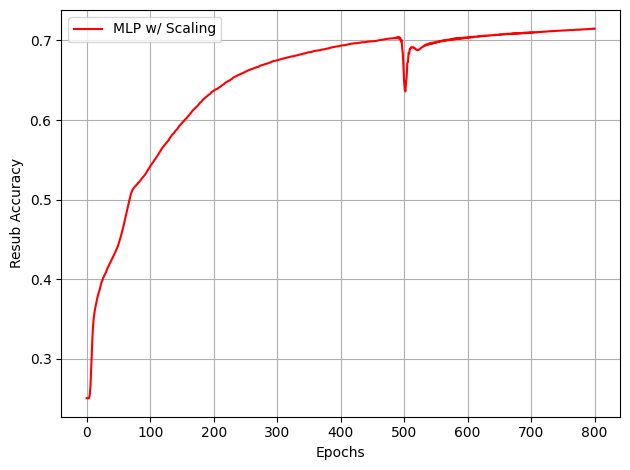

In [112]:
print_result(
    mlp,
    x_train_final.to_numpy(),
    y_train_cat.to_numpy(),
    x_test_final.to_numpy(),
    y_test_cat,
    "MLP w/ Scaling",
    "red",
)
plt.show()